<a href="https://colab.research.google.com/github/VishalRaj0/sentiment-analysis-chatbot/blob/main/Sentiment_Analysis_ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Sentiment Analysis ChatBot using Tensorflow Keras</h1>
<br>
For Teachnook Artificial Intelligence February batch Major Project submission.

<h3>Instructions:-</h3>
<br>
Before running please install all the modules using pip.
<br>
Output of the model is at the bottom of the notebook.


In [ ]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"After the unexpected accident that killed an inexperienced climber (Michelle Joyner). Eight months has passed... The Rocky Mountain Rescue receive a distress call set by a brilliant terrorist mastermind Eric Quaien (John Lithgow). Quaien has lost three large cases that has millions of dollars inside. Two experienced climbers Walker (Sylvester Stallone) and Tucker (Micheal Rooker) and a helicopter pilot (Janine Turner) are to the rescue but they are set by a trap by Quaien and his men. Now the two climbers and pilot are forced to play a deadly game of hide and seek. While Quaien is trying to find the millions of dollars and he kidnapped Tucker to find the money. Once Tucker finds the money, Tucker will be dead. Against explosive firepower, bitter cold and dizzying heights. Walker must outwit Quaien for survival.<br /><br />Directed by Renny Harlin (Driven, Mindhunters, A Nightmare on Elm Street 4:The Dream Master) made an entertaining non-stop action picture. This film is a s

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[101,   2,   1, ...,   0,   0,   0],
       [ 10, 249,  43, ...,   0,   0,   0],
       [ 50, 347, 175, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"After the unexpected accident that killed an inexperienced climber (Michelle Joyner). Eight months has passed... The Rocky Mountain Rescue receive a distress call set by a brilliant terrorist mastermind Eric Quaien (John Lithgow). Quaien has lost three large cases that has millions of dollars inside. Two experienced climbers Walker (Sylvester Stallone) and Tucker (Micheal Rooker) and a helicopter pilot (Janine Turner) are to the rescue but they are set by a trap by Quaien and his men. Now the two climbers and pilot are forced to play a deadly game of hide and seek. While Quaien is trying to find the millions of dollars and he kidnapped Tucker to find the money. Once Tucker finds the money, Tucker will be dead. Against explosive firepower, bitter cold and dizzying heights. Walker must outwit Quaien for survival.<br /><br />Directed by Renny Harlin (Driven, Mindhunters, A Nightmare on Elm Street 4:The Dream Master) made an entertaining non-stop action picture. This film is a

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True]


In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 5s 5s/step
[-0.00464395]


In [ ]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 108ms/step
[-0.00464395]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 81s 160ms/step - loss: 0.6474 - accuracy: 0.5560 - val_loss: 0.4299 - val_accuracy: 0.8141
Epoch 2/10
391/391 [==============================] - 51s 130ms/step - loss: 0.3815 - accuracy: 0.8249 - val_loss: 0.3739 - val_accuracy: 0.8505
Epoch 3/10
391/391 [==============================] - 50s 129ms/step - loss: 0.3338 - accuracy: 0.8546 - val_loss: 0.3391 - val_accuracy: 0.8557
Epoch 4/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3200 - accuracy: 0.8619 - val_loss: 0.3223 - val_accuracy: 0.8531
Epoch 5/10
391/391 [==============================] - 51s 129ms/step - loss: 0.3101 - accuracy: 0.8686 - val_loss: 0.3369 - val_accuracy: 0.8391
Epoch 6/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3093 - accuracy: 0.8670 - val_loss: 0.3206 - val_accuracy: 0.8573
Epoch 7/10
391/391 [==============================] - 49s 125ms/step - loss: 0.3017 - accuracy: 0.8705 - val_loss: 0.3335 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 21s 53ms/step - loss: 0.3217 - accuracy: 0.8551
Test Loss: 0.3216681182384491
Test Accuracy: 0.8551200032234192


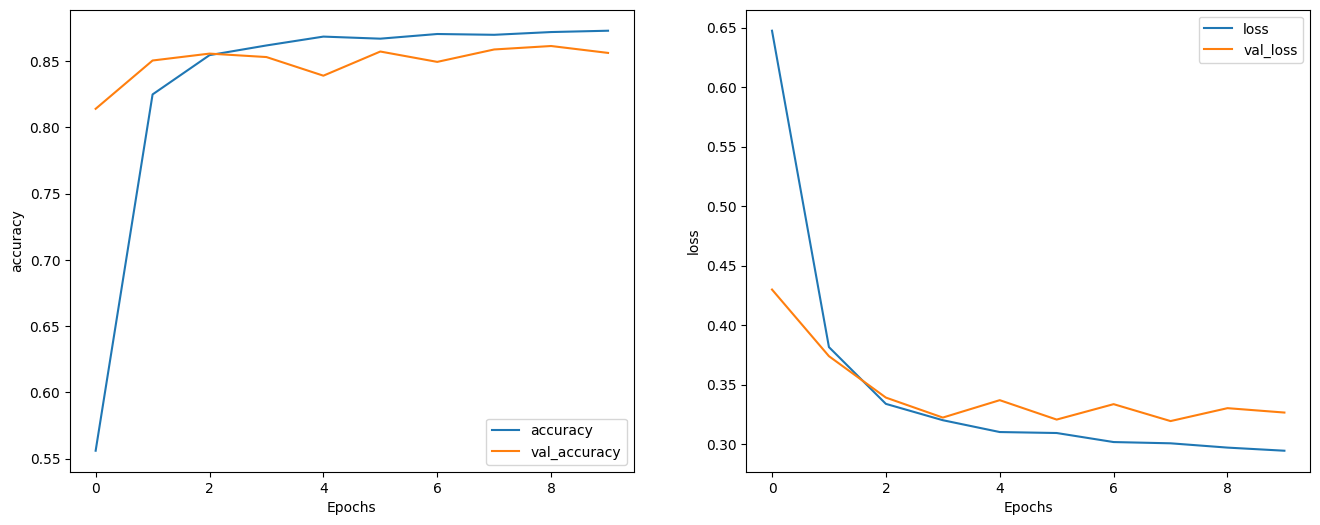

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 0s 98ms/step
[[0.4824682]]


In [ ]:
def sentiment_analysis(predictions):
  if predictions >= 0.45:
    return("Positive")
  elif predictions <= -0.45:
    return("Negative")
  else:
    return("Neutral")

In [ ]:
while(True):
  user_input = (input("You: ").lower())
  if user_input == "quit":
    break
  predictions = model.predict(np.array([user_input]))
  sentiment = sentiment_analysis(predictions)
  print("Your sentiment is:", sentiment)

You: i feel great this morning
1/1 [==============================] - 0s 34ms/step
Your sentiment is: Positive
You: this view is amazing.
1/1 [==============================] - 0s 20ms/step
Your sentiment is: Positive
You: He is my best friend.
1/1 [==============================] - 0s 23ms/step
Your sentiment is: Positive
You: This view is horrible
1/1 [==============================] - 0s 21ms/step
Your sentiment is: Negative
You: I am not looking forward to this concert.
1/1 [==============================] - 0s 21ms/step
Your sentiment is: Negative
You: He is my enemy.
1/1 [==============================] - 0s 21ms/step
Your sentiment is: Neutral
You: There is a book on the desk.
1/1 [==============================] - 0s 20ms/step
Your sentiment is: Neutral
You: Childhood is the time to play
1/1 [==============================] - 0s 22ms/step
Your sentiment is: Neutral
You: Childhood will be terrible without games.
1/1 [==============================] - 0s 21ms/step
Your sentiment 